In [3]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization,SpatialDropout1D,Bidirectional, Embedding, LSTM
from tensorflow.python.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
import re

np.set_printoptions(threshold=sys.maxsize)

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

# GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
labels = ["business", "entertainment", "politics", "sport", "tech"]
targets = [0,1,2,3,4]
dataset = []
for root, dirs, files in os.walk("./archive/bbc", topdown=False):
    class_type = root.split("\\")
    print(class_type)
    if len(class_type)> 1:
        for file in files: 
            with open(root+"/"+file) as f: 
                text = f.read()
                dataset.append([class_type[1], text])  

['./archive/bbc', 'business']
['./archive/bbc', 'entertainment']
['./archive/bbc', 'politics']
['./archive/bbc', 'sport']
['./archive/bbc', 'tech']
['./archive/bbc']


In [3]:
print(len(dataset))

2225


In [4]:
import pickle

with open('./archive/bbc/dataset.list', "wb") as f: 
    pickle.dump(dataset, f)

In [1]:
import pickle

with open('./archive/bbc/dataset.list', "rb") as f: 
    dataset = pickle.load(f)

print(len(dataset))

2225


In [4]:
dataset = pd.DataFrame(list(dataset), columns=["labels", "text"])

<AxesSubplot:xlabel='labels', ylabel='count'>

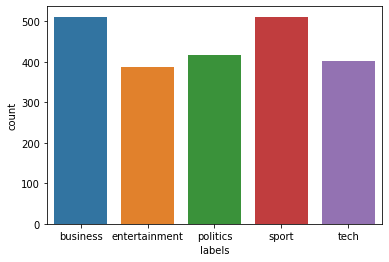

In [5]:
sns.countplot(x="labels", data=dataset)

In [6]:
dataset["labels"] = dataset["labels"].replace({"business":0, "entertainment":1, "politics":2, "sport":3, "tech":4})

In [7]:
X = dataset["text"].values
y = dataset["labels"].values

y = to_categorical(y)

In [8]:
tokenizer = Tokenizer(num_words= None, lower=True)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# # Example
# print(X[0])
# print(sequences[0])

In [29]:
X_encoded = pad_sequences(sequences, maxlen=50, padding='post')

print(X_encoded[0])

[ 4366     2  9962     1   114    12  1165     7     5   216    16   786
    99  4888 20599  2669     3     5  1266     6  3300   264    34    12
    35   613    17  2177  1471    12    22    67   640     1   444     3
    40  1266     6  3300   264    17     5  1197    10     1   792     3
     9  1266]


In [30]:
# Split into training set and test set. Use a test size = 3000 and a random state = 0
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.10, random_state=0,stratify = y)

In [31]:
# Design a LSTM neural network and use an embedding layer.
vocabulary_size = X_train.max()

model = Sequential()

model.add(Embedding(vocabulary_size+1, 150, input_length=50))
model.add(SpatialDropout1D(0.3))
# model.add(LSTM(500,return_sequences=True, dropout=0.2, recurrent_dropout=0.15))
model.add(LSTM(150, dropout=0.10, recurrent_dropout=0.1))
model.add(Dense(750, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [32]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import time
from datetime import datetime, date
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.001, patience=5, restore_best_weights=True)

END = f'{datetime.timestamp(datetime.now())}_{date.today().strftime("%b-%d-%Y")}'

NAME = 'logs/bbc/bbc_classification_log_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir=f'{NAME}_{END}')

checkpoint_filepath = f'models/bbc/bbc_classification_{END}.h5'
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)

callback_list = [tensorboard, checkpointer, es]

In [33]:
history = model.fit(X_train, y_train, epochs=100,verbose=1,batch_size=128, validation_split=0.2, callbacks=callback_list)

Epoch 1/100
13/13 [==============================] - 16s 1s/step - loss: 1.6048 - accuracy: 0.2505 - val_loss: 1.5878 - val_accuracy: 0.2494
Epoch 2/100
13/13 [==============================] - 14s 1s/step - loss: 1.4344 - accuracy: 0.3823 - val_loss: 1.2417 - val_accuracy: 0.4713
Epoch 3/100
13/13 [==============================] - 11s 818ms/step - loss: 1.0358 - accuracy: 0.4991 - val_loss: 1.0110 - val_accuracy: 0.6409
Epoch 4/100
13/13 [==============================] - 11s 826ms/step - loss: 0.6985 - accuracy: 0.7570 - val_loss: 0.8574 - val_accuracy: 0.6209
Epoch 5/100
13/13 [==============================] - 11s 830ms/step - loss: 0.3174 - accuracy: 0.9113 - val_loss: 0.7708 - val_accuracy: 0.7257
Epoch 6/100
13/13 [==============================] - 11s 825ms/step - loss: 0.1130 - accuracy: 0.9669 - val_loss: 0.7437 - val_accuracy: 0.7606
Epoch 7/100
13/13 [==============================] - 11s 873ms/step - loss: 0.0491 - accuracy: 0.9869 - val_loss: 0.8633 - val_accuracy: 0.760

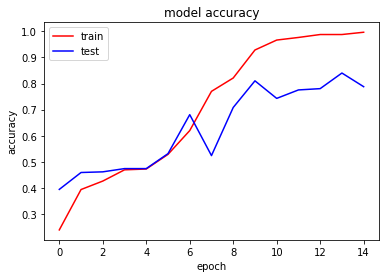

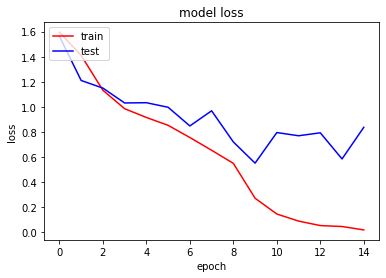

In [27]:
# Plot history

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
# Validate model on training set
rounded_labels=np.argmax(y_test, axis=1)

y_pred = np.argmax(model.predict(X_test),axis=-1)

print(classification_report(rounded_labels, y_pred))

cf = confusion_matrix(rounded_labels, y_pred)

print(cf)
print(accuracy_score(rounded_labels, y_pred) * 100) 

              precision    recall  f1-score   support

           0       0.98      0.80      0.88        51
           1       0.76      0.74      0.75        39
           2       0.63      0.74      0.68        42
           3       0.96      1.00      0.98        51
           4       0.73      0.75      0.74        40

    accuracy                           0.82       223
   macro avg       0.81      0.81      0.81       223
weighted avg       0.83      0.82      0.82       223

[[41  0  5  0  5]
 [ 0 29  8  2  0]
 [ 0  5 31  0  6]
 [ 0  0  0 51  0]
 [ 1  4  5  0 30]]
81.61434977578476
